In [163]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [164]:
def load_and_process_data(file_path):
    processed_data = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                data = json.loads(line)
                group_id = data['group']
                current_probe_counts_vector = data['probe_counts']

                if group_id not in processed_data:
                    processed_data[group_id] = {
                        'probe_counts_vectors': [],
                        'vector_length': 0
                    }

                if len(processed_data[group_id]['probe_counts_vectors']) < 30:
                    processed_data[group_id]['probe_counts_vectors'].append(current_probe_counts_vector)

                if processed_data[group_id]['vector_length'] == 0 and current_probe_counts_vector:
                    processed_data[group_id]['vector_length'] = len(current_probe_counts_vector)

        print("Successfully loaded and processed group_traces.jsonl")
        print("\nGroups loaded:", list(processed_data.keys()))

        if processed_data:
            first_group_key = list(processed_data.keys())[0]
            # print(f"\nExample entry for '{first_group_key}':\n", processed_data[first_group_key])
        else:
            print("No data was processed.")
        return processed_data

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [165]:
def calculate_minimized_vectors(processed_data):
    minimized_vectors_per_group = {}

    if processed_data is None: # Handle case where data loading failed
        print("Cannot calculate minimized vectors: processed_data is None.")
        return None

    for group_id, group_data in processed_data.items():
        probe_vectors = group_data['probe_counts_vectors']

        if probe_vectors:
            np_probe_vectors = np.array(probe_vectors)
            minimized_vector = np.min(np_probe_vectors, axis=0)
            minimized_vectors_per_group[group_id] = minimized_vector.tolist()

    print("Successfully calculated minimized probe count vectors for the following groups:", list(minimized_vectors_per_group.keys()))

    if minimized_vectors_per_group:
        first_minimized_group_key = list(minimized_vectors_per_group.keys())[0]
        # print(f"\nExample minimized vector for group '{first_minimized_group_key}':\n", minimized_vectors_per_group[first_minimized_group_key])
    else:
        print("No minimized vectors were computed.")
    return minimized_vectors_per_group

In [166]:
import numpy as np

def hierarchical_group_sort(vectors_dict, threshold=1, override=False):
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)

    num_groups, width = M.shape
    col_order = np.arange(width)

    next_start = 0
    # Override values < threshold with 0 for ALL groups if override is True
    if override:
        M = np.where(M < threshold, 0, M)

    for g in range(num_groups):
            
        # 1) Sort the slice M[g, next_start:] in descending order
        slice_vec = M[g, next_start:]
        local_indices = np.argsort(slice_vec)[::-1]  # descending

        # Build full permutation for this stage
        perm = np.concatenate([
            np.arange(next_start),               # untouched prefix
            next_start + local_indices           # reordered suffix
        ])

        # Apply permutation globally
        M = M[:, perm]
        col_order = col_order[perm]

        # 2) Update next_start:
        # Find first index where the value < threshold (after sorting)
        new_region = M[g, next_start:]
        above_threshold_positions = np.where(new_region >= threshold)[0]

        if len(above_threshold_positions) > 0:
            # Set next_start to the first position with value < threshold
            next_start = next_start + above_threshold_positions[-1] + 1
        else:
            # All remaining values are >= threshold, can't sort anymore
            break


        # If next_start reaches the end → done
        if next_start >= width:
            break

    # Build result dict again
    out = {}
    for i, k in enumerate(group_keys):
        out[k] = M[i].tolist()

    return out, col_order.tolist()


In [167]:
def generate_all_heatmaps(groups_vector, filename_prefix="heatmap"):

    if groups_vector is None or not groups_vector:
        print("No averaged vectors available for heatmap generation.")
        return

    heatmaps_dir = "heatmaps"
    os.makedirs(heatmaps_dir, exist_ok=True)

    # Stack all averaged vectors into a single 2D NumPy array
    # Each row will be a group's averaged vector, and columns will be probe indices
    all_averaged_data = np.array(list(groups_vector.values()))

    print(f"Shape of the combined data for heatmap: {all_averaged_data.shape}")

    # Create the heatmap
    plt.figure(figsize=(20, 10)) # Adjust figure size for better readability given the large number of columns
    sns.heatmap(all_averaged_data, cmap='viridis', cbar=True, yticklabels=list(groups_vector.keys()))

    plt.title('Heatmap of Averaged Probe Counts Across All Groups and Probe Indices')
    plt.xlabel('Probe Index (12288 cells)')
    plt.ylabel('Group ID (64 groups)')
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
        # Save the heatmap to file
    output_path = os.path.join(heatmaps_dir, f"{filename_prefix}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved to: {output_path}")
    
    plt.show()

    print("Heatmap generation complete.")

In [168]:
def threshold_vector(v, T):
    v2 = np.copy(v)
    v2[v2 < T] = 0
    return v2

def cosine_similarity(a, b):
    if np.all(a == 0) or np.all(b == 0):
        return 0   # define similarity with zero-vector as 0
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def pairwise_cosine_complement_score(matrix, threshold=1):
    # matrix = list of np.array, one per group
    sims = []
    for i in range(len(matrix)):
        for j in range(i+1, len(matrix)):
            v1 = threshold_vector(matrix[i], threshold)
            v2 = threshold_vector(matrix[j], threshold)
            sims.append(cosine_similarity(v1, v2))
    
    mean_sim = np.mean(sims)
    final_score = 1 - mean_sim
    return final_score

def run_cosine_analysis(vectors_dict, threshold=3):
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)
    score = pairwise_cosine_complement_score(M, threshold=threshold)
    print(f"Cosine analysis score: {score}")

In [169]:
def calculate_coverage_metric(minimized_vectors_per_group, s, w, group_prime=0):

    if minimized_vectors_per_group is None or not minimized_vectors_per_group:
        print("No minimized vectors available for coverage calculation.")
        return 0.0
    
    if group_prime not in minimized_vectors_per_group:
        print(f"Group {group_prime} not found in data.")
        return 0.0
    
    # Get the primary group's vector
    primary_group_vector = np.array(minimized_vectors_per_group[group_prime])
    
    # Calculate sum of misses from index 0 to s-1 (s sets)
    if len(primary_group_vector) < s:
        print(f"Warning: Vector length ({len(primary_group_vector)}) is less than number of sets ({s})")
        sum_of_misses = np.sum(primary_group_vector)
    else:
        sum_of_misses = np.sum(primary_group_vector[:s])
    
    # Calculate score
    denominator = s * w
    if denominator == 0:
        print("Error: s × w cannot be zero")
        return 0.0
    
    score = sum_of_misses / denominator
    
    print(f"Coverage Metric Calculation:")
    print(f"  Sets (s): {s}")
    print(f"  Ways (w): {w}")
    print(f"  Sum of misses (0 to {s-1}): {sum_of_misses}")
    print(f"  Score: {sum_of_misses} / ({s} × {w}) = {score:.6f}")
    
    return score

def run_coverage_analysis(minimized_vectors_per_group, s, w):
    """
    Run coverage analysis for all groups and return results.
    
    Args:
        minimized_vectors_per_group: Dictionary with group_id as key and minimized vector as value
        s: Number of sets in cache (default: 512 for typical L3 cache)
        w: Number of ways in a set (default: 8 for typical L3 cache)
    
    Returns:
        dict: Coverage scores for all groups
    """
    if minimized_vectors_per_group is None:
        return {}
    
    coverage_scores = {}
    
    print(f"\n=== Coverage Analysis (s={s}, w={w}) ===")
    
    for group_id in sorted(minimized_vectors_per_group.keys()):
        score = calculate_coverage_metric(minimized_vectors_per_group, s, w, group_id)
        coverage_scores[group_id] = score
    
    # Summary statistics
    if coverage_scores:
        scores = list(coverage_scores.values())
        print(f"\nCoverage Summary:")
        print(f"  Mean score: {np.mean(scores):.6f}")
        print(f"  Std deviation: {np.std(scores):.6f}")
        print(f"  Min score: {np.min(scores):.6f} (Group {min(coverage_scores, key=coverage_scores.get)})")
        print(f"  Max score: {np.max(scores):.6f} (Group {max(coverage_scores, key=coverage_scores.get)})")
    
    return coverage_scores

In [170]:

# jsonl_files = glob.glob('../data/24MB/*.jsonl')
jsonl_files = glob.glob('../data/12MB/*.jsonl')

print("Found JSONL files:", jsonl_files)

Found JSONL files: ['../data/12MB/16_group_prime.jsonl', '../data/12MB/4_group_prime.jsonl', '../data/12MB/32_group_prime.jsonl', '../data/12MB/1_group_no_prime1.jsonl', '../data/12MB/2_group_prime.jsonl', '../data/12MB/8_group_prime.jsonl', '../data/12MB/64_group_prime.jsonl', '../data/12MB/1_group_no_prime0.jsonl', '../data/12MB/1_group_prime.jsonl']


## Process and Plot Heatmaps for Each File

### Subtask:
Iterate through each `.jsonl` file found. For each file, load and process the data, calculate the averaged vectors, and then generate and display a heatmap using the `generate_all_heatmaps` function. This will produce a separate heatmap for each data file.


**Reasoning**:
I will iterate through each `.jsonl` file, process its data, calculate averaged vectors, and then generate a heatmap for each file using the functions defined earlier, as instructed.




Processing file: ../data/12MB/16_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cosine analysis score: 0.9028838598596454
Shape of the combined data for heatmap: (16, 16384)
Heatmap saved to: heatmaps/16_group_prime.png


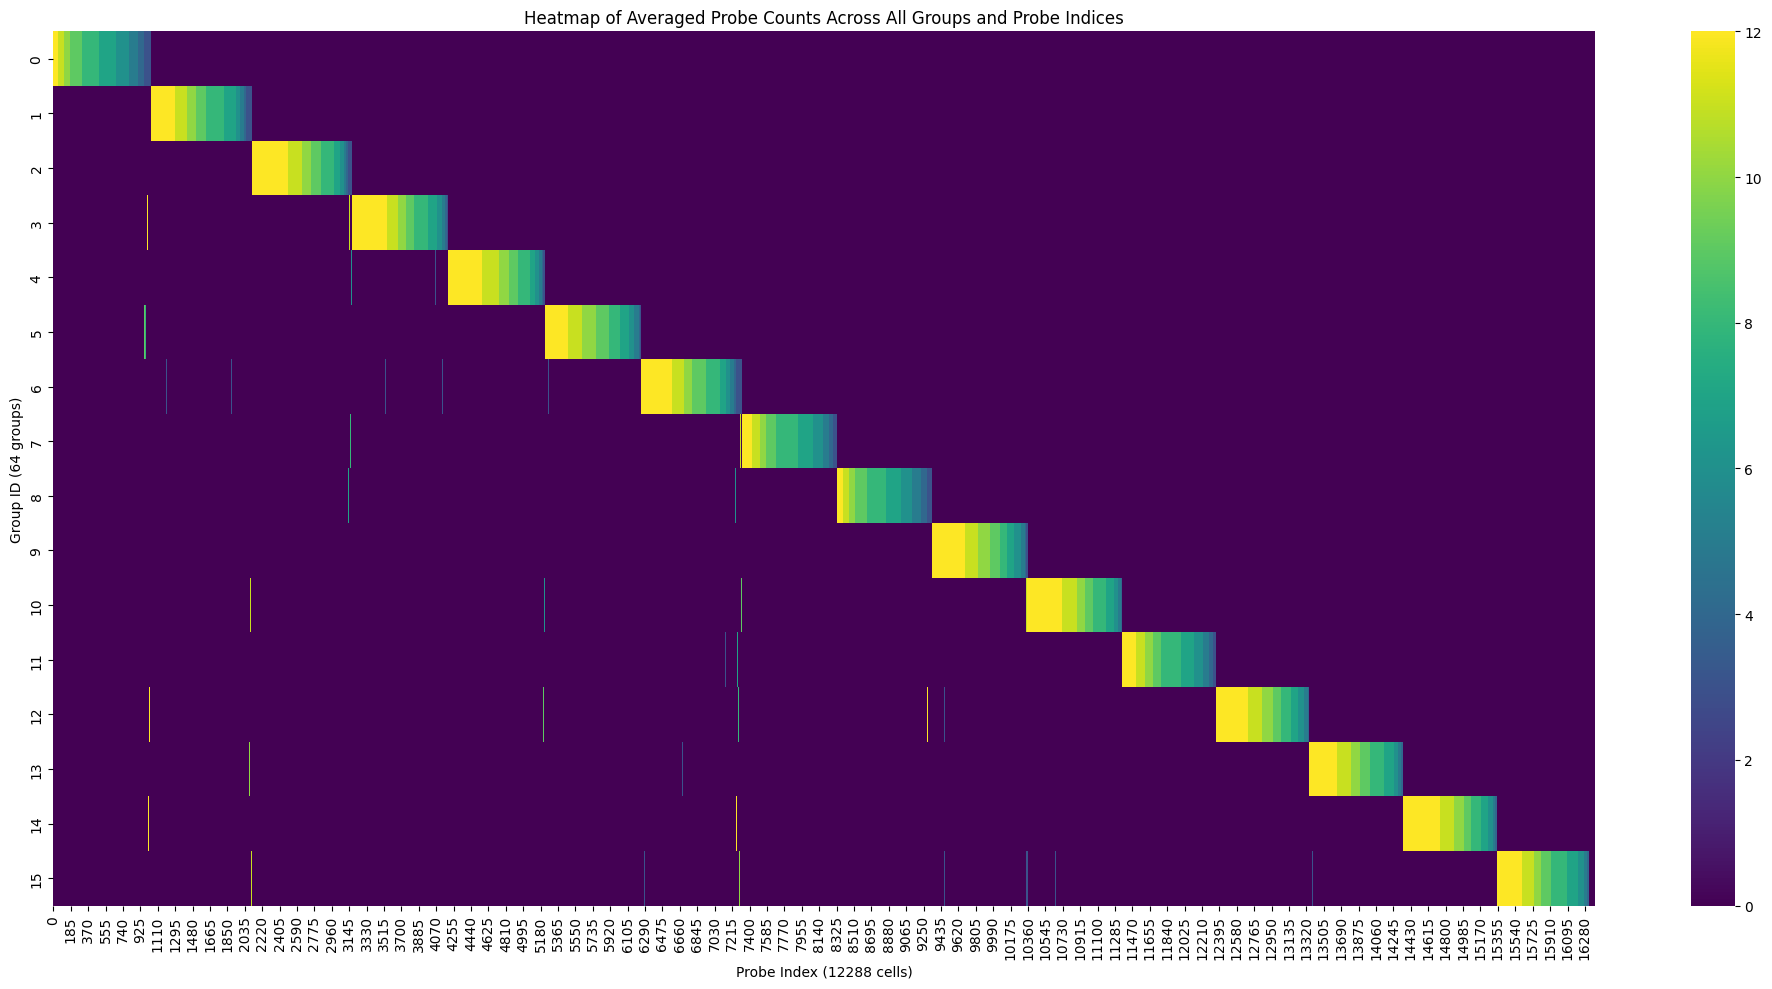

Heatmap generation complete.

Processing file: ../data/12MB/4_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3]
Cosine analysis score: 0.7569032069677042
Shape of the combined data for heatmap: (4, 16384)
Heatmap saved to: heatmaps/4_group_prime.png


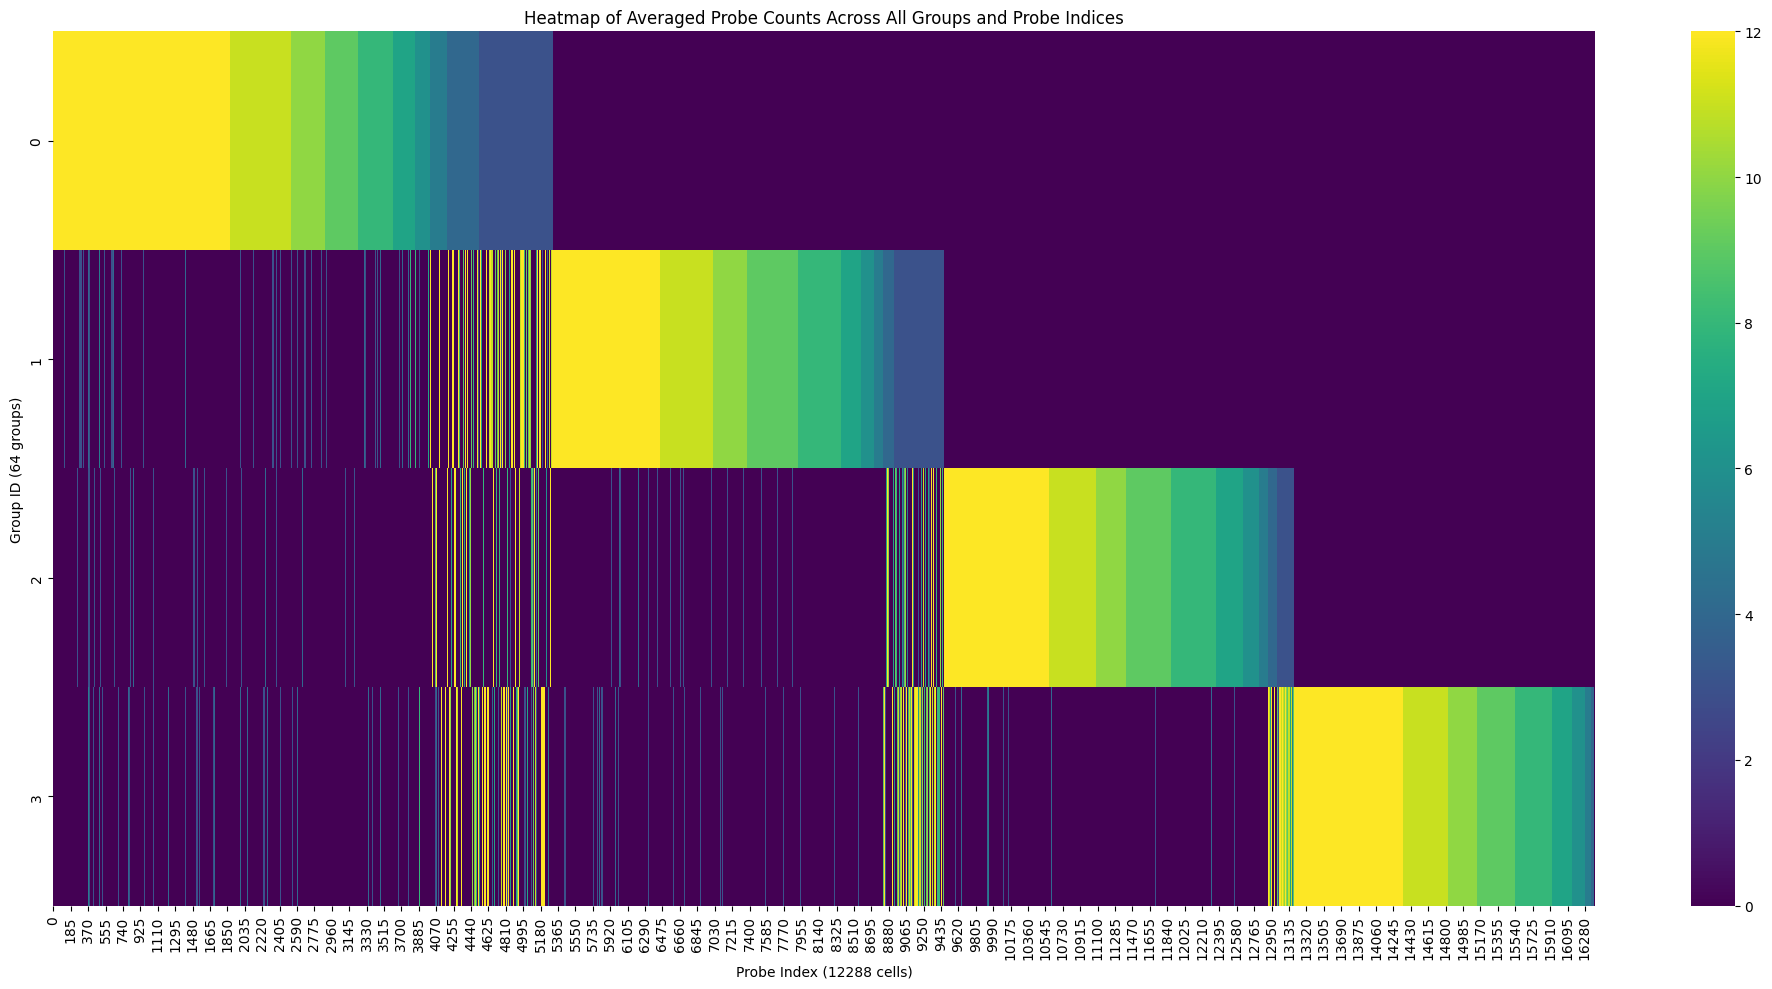

Heatmap generation complete.

Processing file: ../data/12MB/32_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Cosine analysis score: 0.8925068972115899
Shape of the combined data for heatmap: (32, 16384)
Heatmap saved to: heatmaps/32_group_prime.png


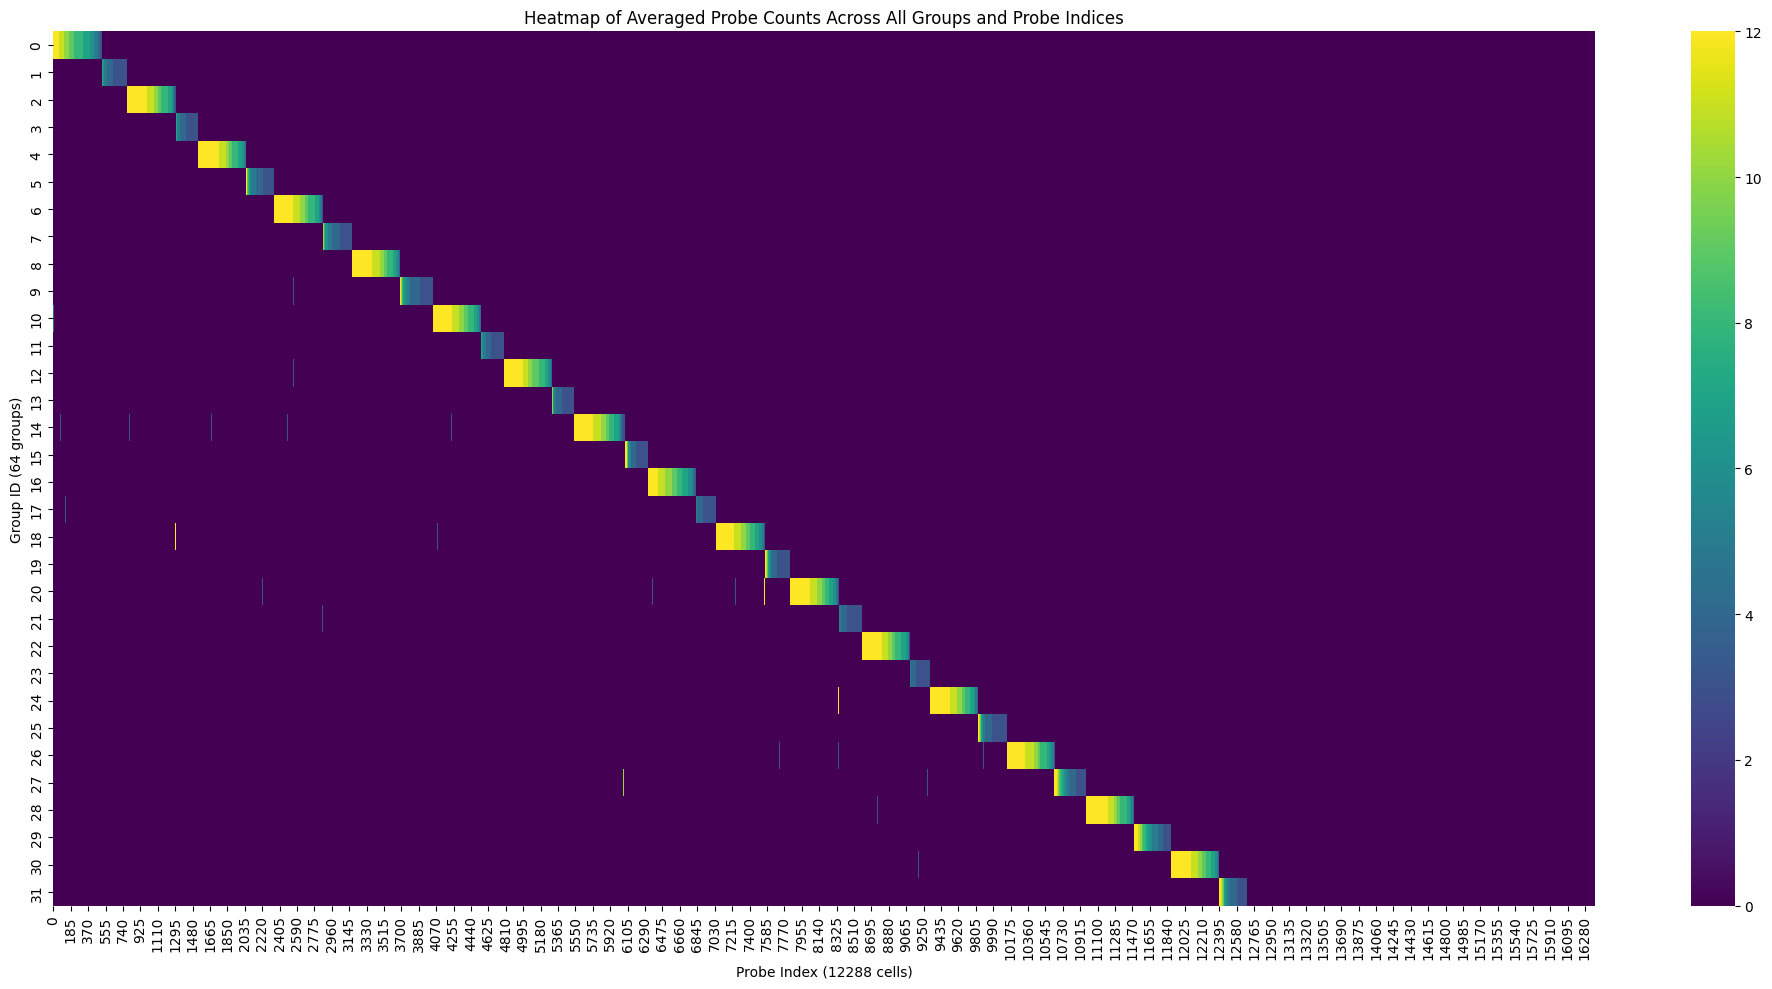

Heatmap generation complete.

Processing file: ../data/12MB/1_group_no_prime1.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_no_prime1.png


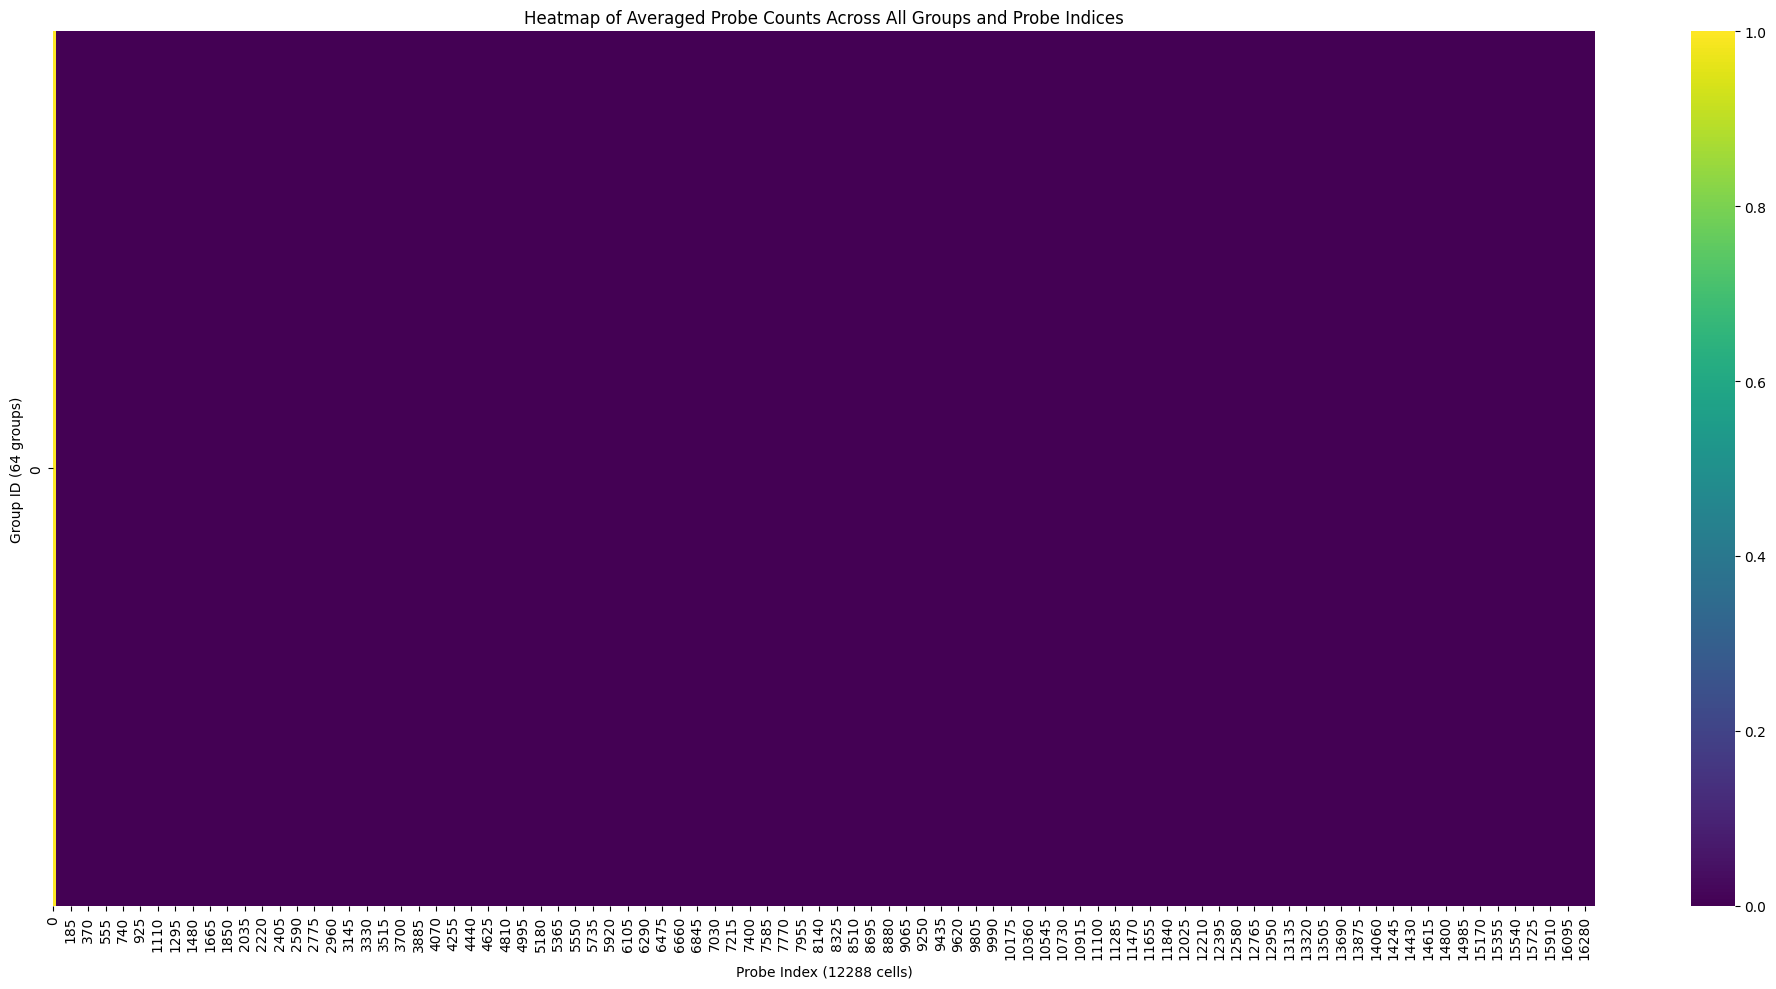

Heatmap generation complete.

Processing file: ../data/12MB/2_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1]
Successfully calculated minimized probe count vectors for the following groups: [0, 1]
Cosine analysis score: 0.6236233992714596
Shape of the combined data for heatmap: (2, 16384)
Heatmap saved to: heatmaps/2_group_prime.png


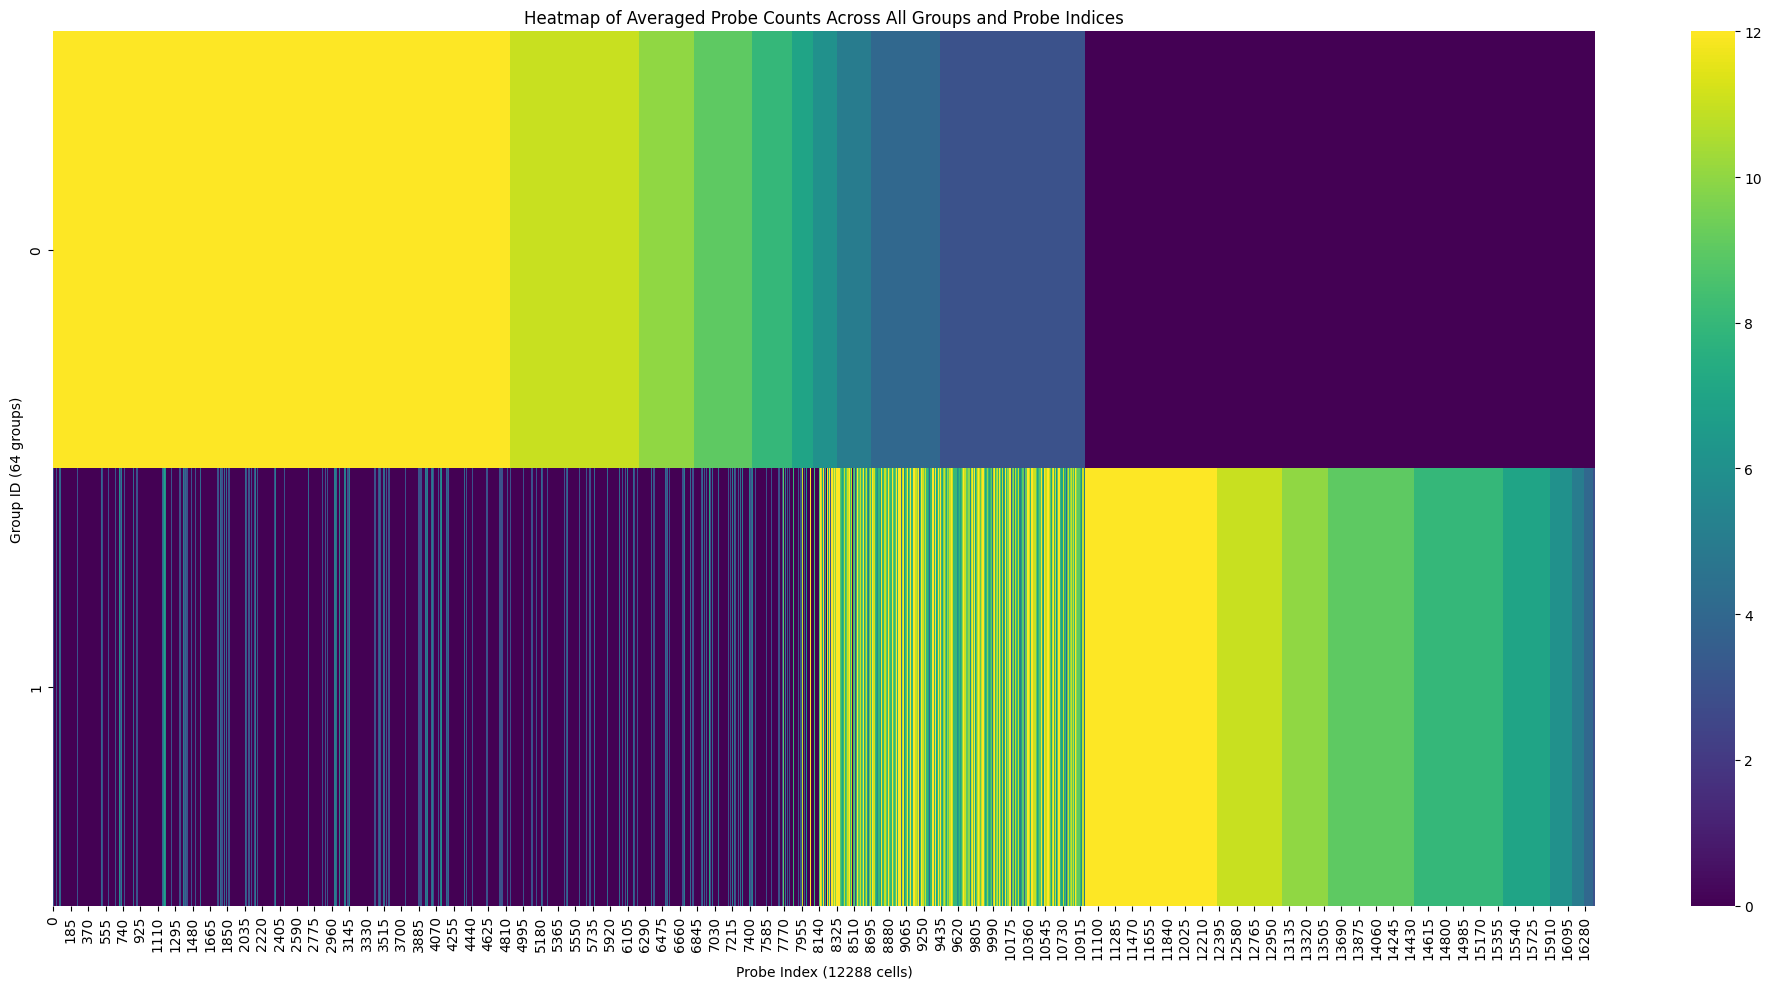

Heatmap generation complete.

Processing file: ../data/12MB/8_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7]
Cosine analysis score: 0.8453106932642525
Shape of the combined data for heatmap: (8, 16384)
Heatmap saved to: heatmaps/8_group_prime.png


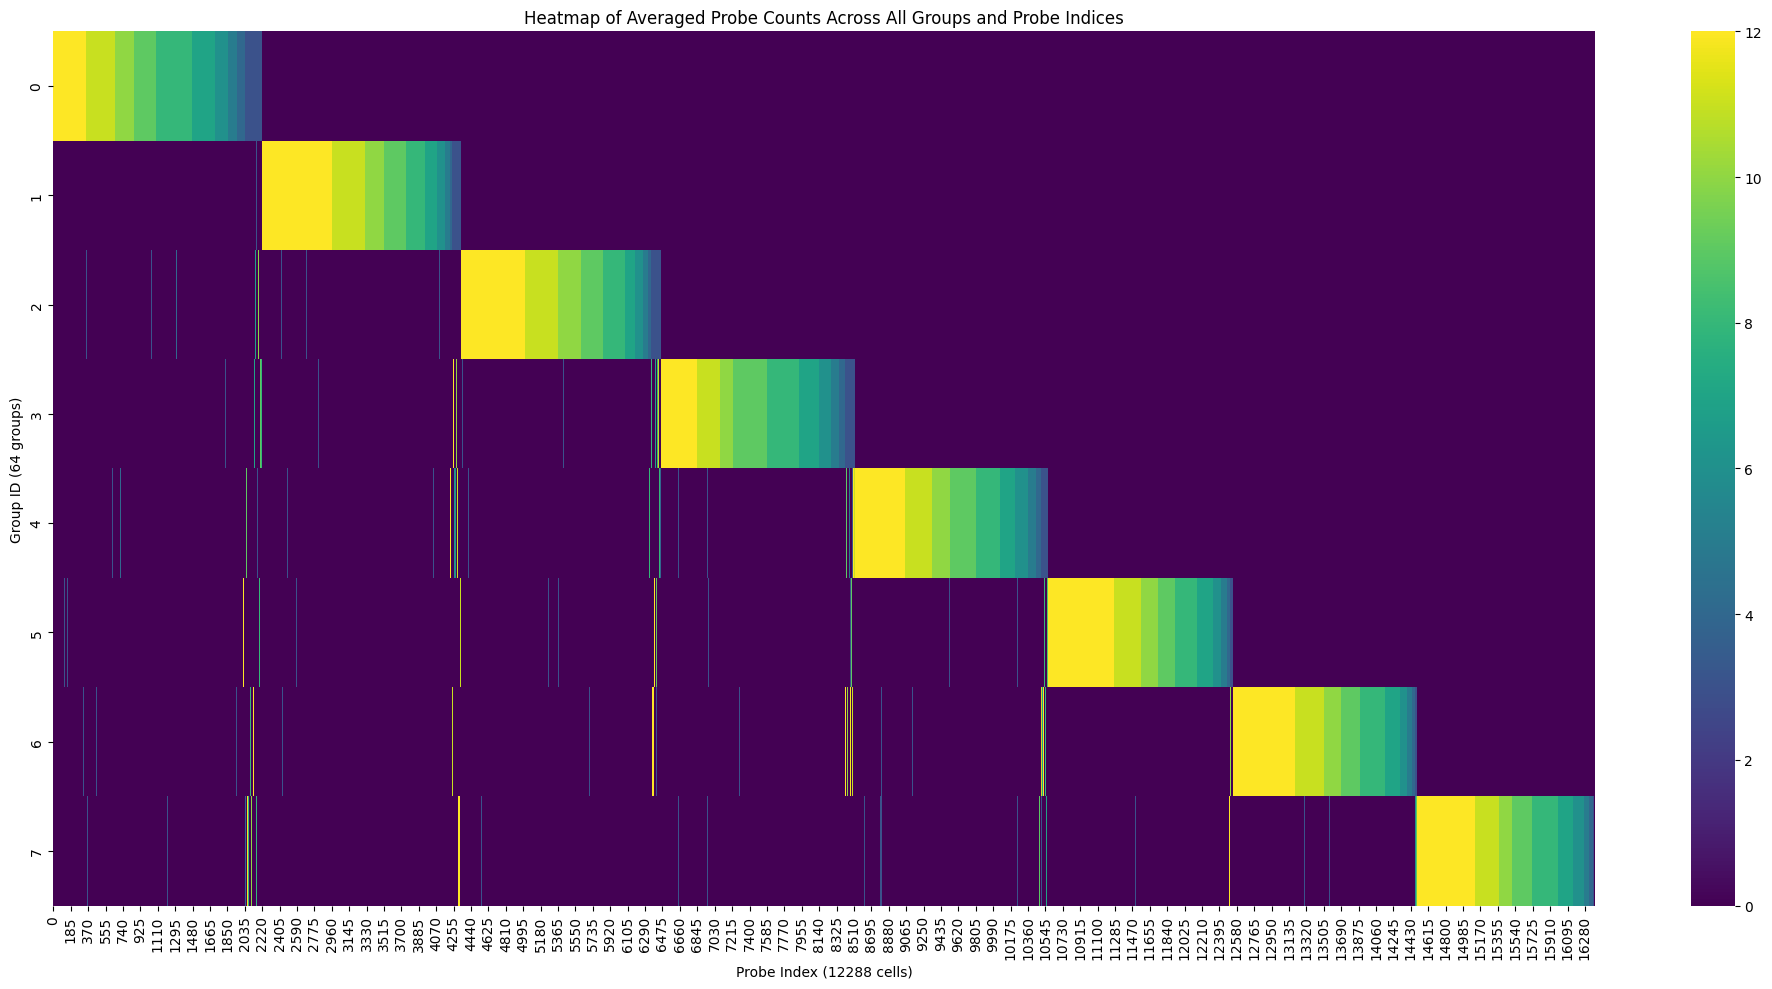

Heatmap generation complete.

Processing file: ../data/12MB/64_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Cosine analysis score: 0.8466550716352336
Shape of the combined data for heatmap: (64, 16384)
Heatmap saved to: heatmaps/64_group_prime.png


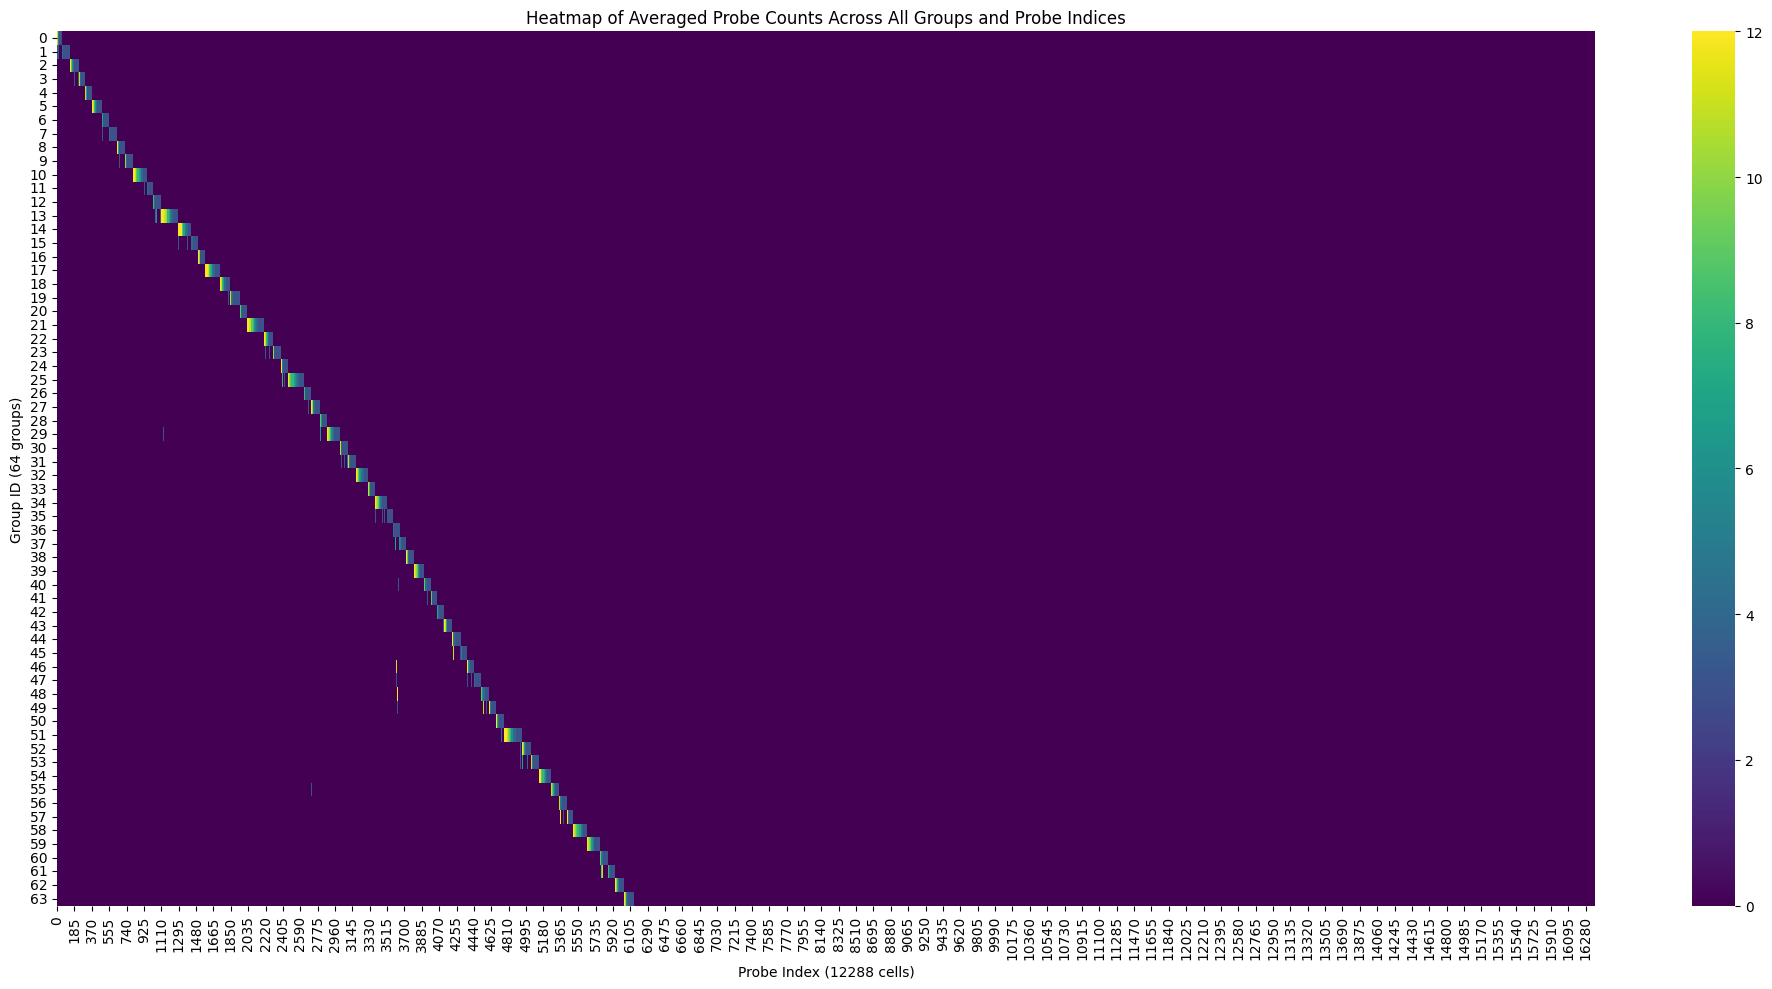

Heatmap generation complete.

Processing file: ../data/12MB/1_group_no_prime0.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_no_prime0.png


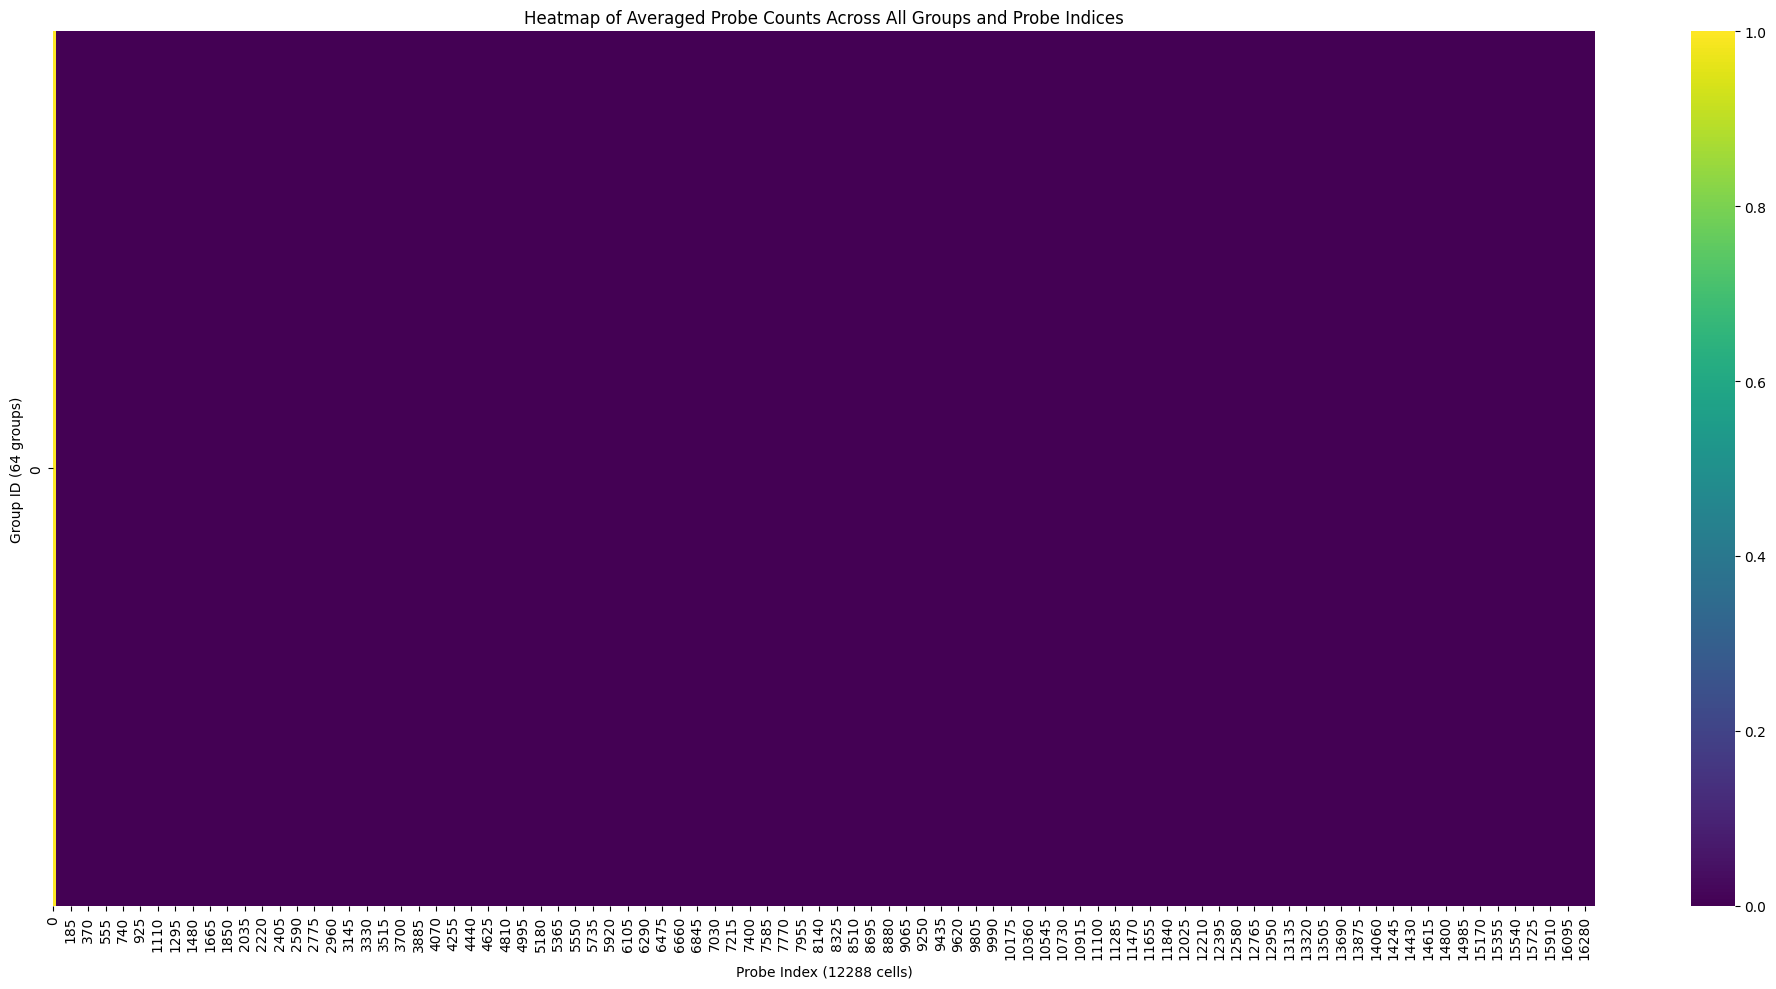

Heatmap generation complete.

Processing file: ../data/12MB/1_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]

=== Coverage Analysis (s=16384, w=12) ===
Coverage Metric Calculation:
  Sets (s): 16384
  Ways (w): 12
  Sum of misses (0 to 16383): 124837
  Score: 124837 / (16384 × 12) = 0.634954

Coverage Summary:
  Mean score: 0.634954
  Std deviation: 0.000000
  Min score: 0.634954 (Group 0)
  Max score: 0.634954 (Group 0)
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_prime.png


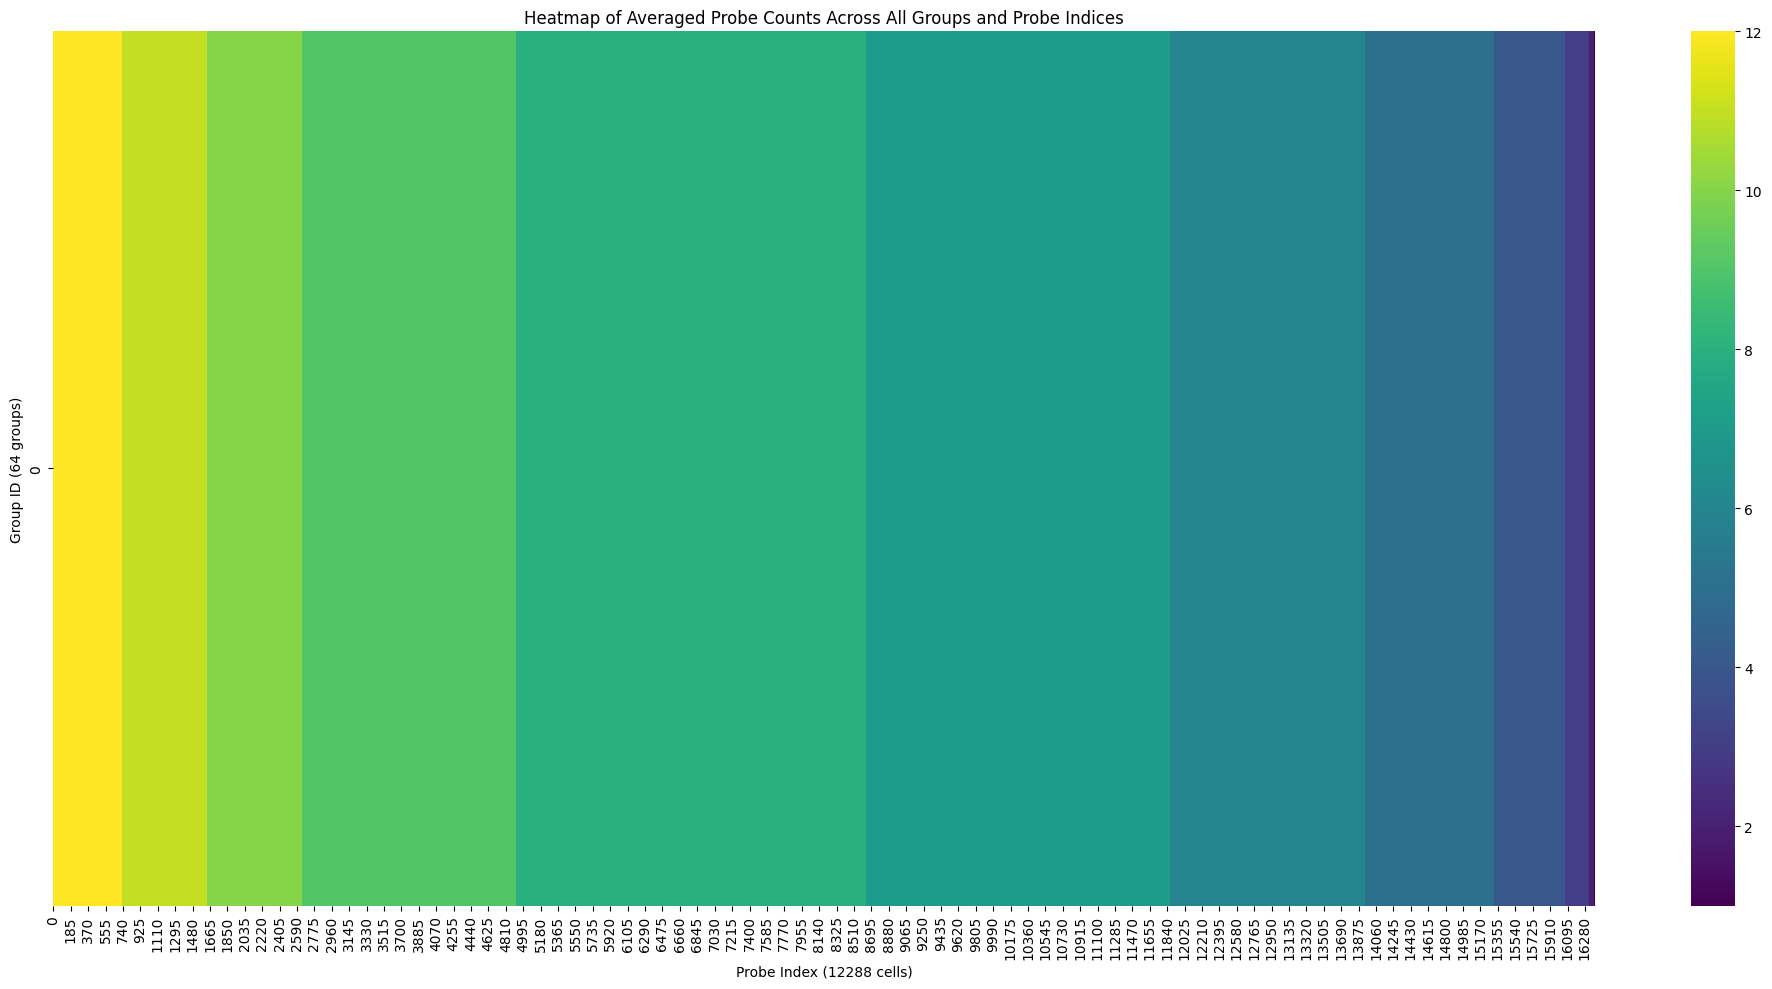

Heatmap generation complete.


In [171]:
for file_path in jsonl_files:
    print(f"\nProcessing file: {file_path}")
    processed_data = load_and_process_data(file_path)
    if processed_data:
        minimized_vectors_per_group = calculate_minimized_vectors(processed_data)
        filename_base = os.path.splitext(os.path.basename(file_path))[0]
        
        # Check if filename starts with "1_"
        if filename_base.startswith('1_'):
            # Use override=False for files starting with "1"
            reordered_vectors, col_order = hierarchical_group_sort(minimized_vectors_per_group, threshold=3, override=False)         
            # Check if the specific file is "1_group_prime.jsonl"
            if filename_base == '1_group_prime':
                coverage_scores = run_coverage_analysis(minimized_vectors_per_group, s=16384, w=12)
        else:
            # Use override=True for other files
            run_cosine_analysis(minimized_vectors_per_group, threshold=1)
            reordered_vectors, col_order = hierarchical_group_sort(minimized_vectors_per_group, threshold=3, override=True)
        
        
        if minimized_vectors_per_group:
            # generate_all_heatmaps(minimized_vectors_per_group, filename_prefix=filename_base)
            generate_all_heatmaps(reordered_vectors, filename_prefix=filename_base)


        else:
            print(f"Could not calculate minimized vectors for {file_path}.")
    else:
        print(f"Could not load and process data from {file_path}.")